In [1]:
from IPython.display import HTML

HTML('''<script>
code_hide=true; 
function code_toggle() {
 if (code_hide){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_hide = !code_hide
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Por defecto el código está oculto. Clickear acá para mostrar/ocultar código."></form>''')

In [ ]:
# SOLO PARA CORRER EN COLAB DDE GH
!git clone https://github.com/tvillani22/PSeI.git # Master
import sys
import os
sys.path.append('/content/PSeI/')
os.chdir('PSeI/')

In [2]:
import numpy as np
import scipy.fft as fft
import scipy.signal as ss
import scipy.ndimage as si
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as tck
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
import PIL.Image
from IPython import display
mpl.rcParams['axes.titlesize']=13

***
<h1 style="color:black;font-size:40px"><center>MÓDULO 5</center></h1>

***
***

# 5.3 Actividad 13

***
>***Implementar y aplicar filtros en el dominio frecuencial (pasabajos y pasaaltos; ideal, gaussiano y butterworth).<br> 
Si querés, podrías generar una función de Matlab que tenga por argumento: Imagen y frecuencia de corte y devuelva las seis imágenes filtradas (u otra variante que consideres más adecuada).***
***

***Abro la imagen, calculo su transformada y visualizo en espacio y en frecuencia (log)...***

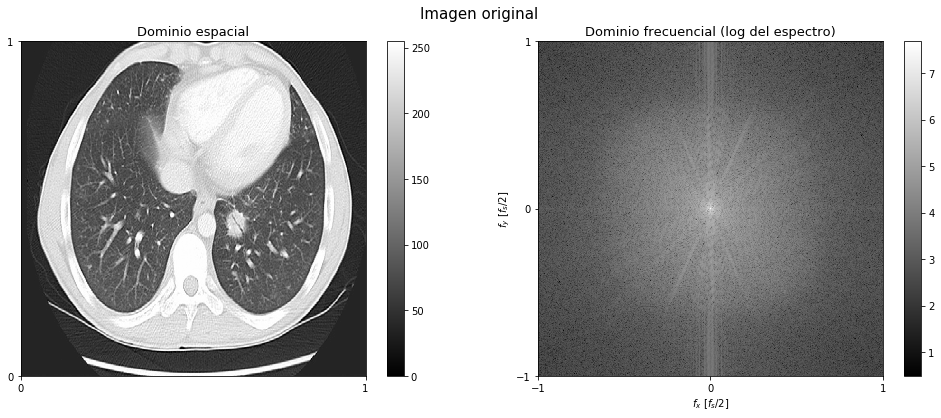

In [9]:
img = mpl.image.imread('Data/Torax.bmp')
img = np.delete(img,(-1), axis=0)
M, N = img.shape

mi_fft = lambda f: fft.fftshift(fft.fft2(f))
F = mi_fft(img)
axis_f = {'xticks': range(-1,2), 'yticks': range(-1,2),
          'xlabel':'$f_x$ $[f_s/2]$', 'ylabel':'$f_y$ $[f_s/2]$'}    # paráms ejes plot frecuencia

def visualizar(imgs,tit,vmax=None):
    fig, ax = plt.subplots(1, 2, figsize=(17,6))
    fig.suptitle(tit, fontsize=15)
    subs = ['Dominio espacial', 'Dominio frecuencial (log del espectro)']
    extents = [[0, 1, 0, 1], [-1, 1, -1, 1]]    
    customs = [{'xticks':[0,1], 'yticks':[0,1]}, axis_f]
    #extents = [[0, M, 0, N], [-1, 1, -1, 1]]
    #customs = [{'xticks':[0,M], 'yticks':[0,N]}, axis_f]
    for axx, img, extent, sub, cust in zip(ax, [imgs[0], np.log10(abs(imgs[1]) + 1)], extents, subs, customs):
        cb = axx.imshow(img, cmap='gray', vmax=vmax, aspect='auto', extent=extent)
        axx.set_title(sub)
        fig.colorbar(cb, ax=axx)
        fig.subplots_adjust(top=0.9)
        axx.set(**cust)
    return

visualizar([img, F], 'Imagen original')

***
## Filtros pasabajos

***Uso la normalización de frecuencias en unidades de $\frac{2f}{f_s}$, para armar el dominio de frecuencias como un cuadrado de lado 2 en el que se inscriba una circunferencia de radio 1. En ese dominio armo la respuesta en frecuencia de los filtros y la visualizo...***

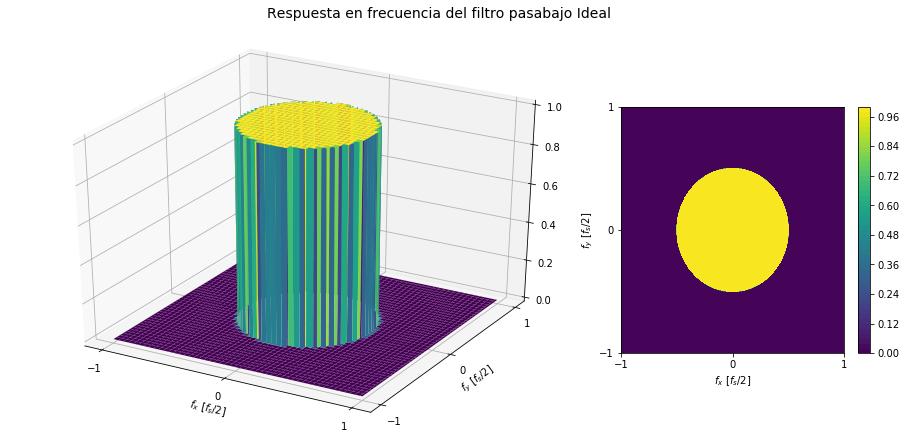

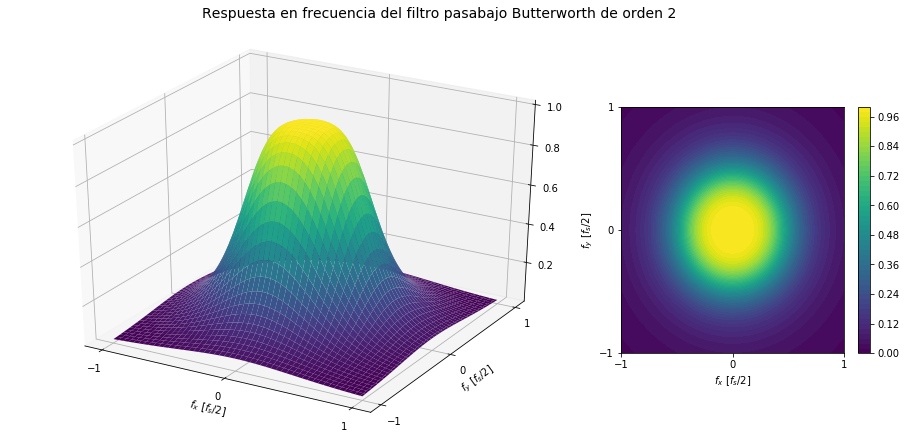

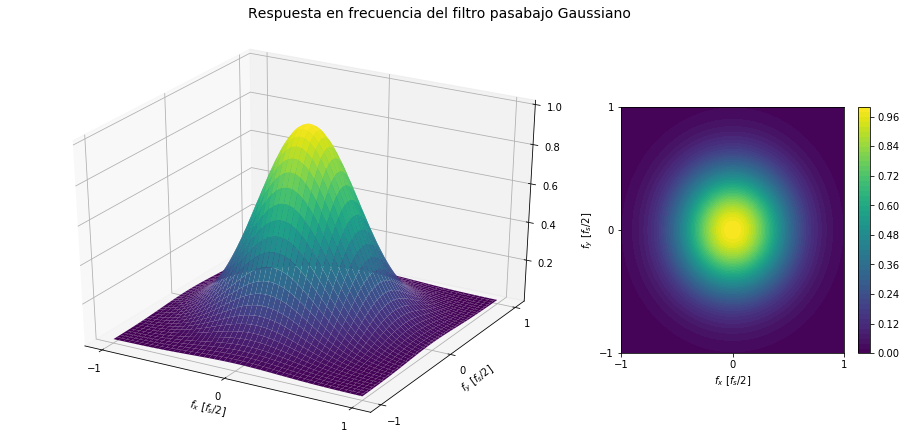

In [13]:
# Dominio de frecuencias
stepfx = 2/N
stepfy = 2/M
wx, wy = np.meshgrid(np.arange(-1+stepfx/2, 1+stepfx/2, stepfx), np.arange(-1+stepfy/2, 1+stepfy/2,stepfy))

# ARMO LOS FILTROS
# Parámetros comunes..
D = (wx**2 + wy**2)**(1/2)   # matriz de "distancias"
D0 = 0.5                     # frecuencia de corte (en unidades de fs/2)

# Filtro ideal
ILPF = np.ones_like(D)
ILPF[D>D0] = 0

# Filtro Butterworth
n = 2                        # orden
BLPF = (1 + (D/D0)**(2*n))**(-1)

# Filtro Gaussiano
GLPF = np.exp(-D**2/D0**2)

# Armo función para visualizar funciones de transferencia de filtros
def visualizar_filtro(H, tit):
    grid = plt.GridSpec(5, 3, wspace=0.1, hspace=0.1)
    fig = plt.figure(figsize=(16,7))
    fig.suptitle('Respuesta en frecuencia del filtro '+tit, fontsize=14)
    ax = fig.add_subplot(grid[:,0:2], projection='3d')
    ax.plot_surface(wx, wy, H, cmap='viridis', edgecolor='none')
    ax.set(**axis_f)
    ax = fig.add_subplot(grid[1:4,2:])
    cb = ax.contourf(wx, wy, H, 50, cmap='viridis')
    fig.subplots_adjust(top=0.95)
    ax.set(**axis_f)
    fig.colorbar(cb, ax=ax)
    return

# Visualizo las 3 rtas en frecuencia..
filtros_pb = [ILPF, BLPF, GLPF]
nombres = ['Ideal', 'Butterworth de orden {}'.format(n), 'Gaussiano']
for filtro, nombre in zip(filtros_pb, nombres):
    visualizar_filtro(filtro, 'pasabajo ' + nombre)

***Hago el producto elemento a elemento con la transfromada centrada de la imagen, vuelvo al domino espacial y visualizo...***

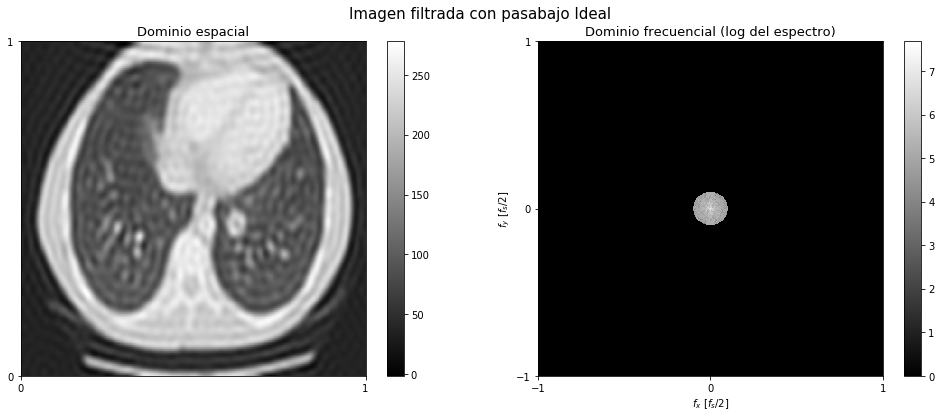

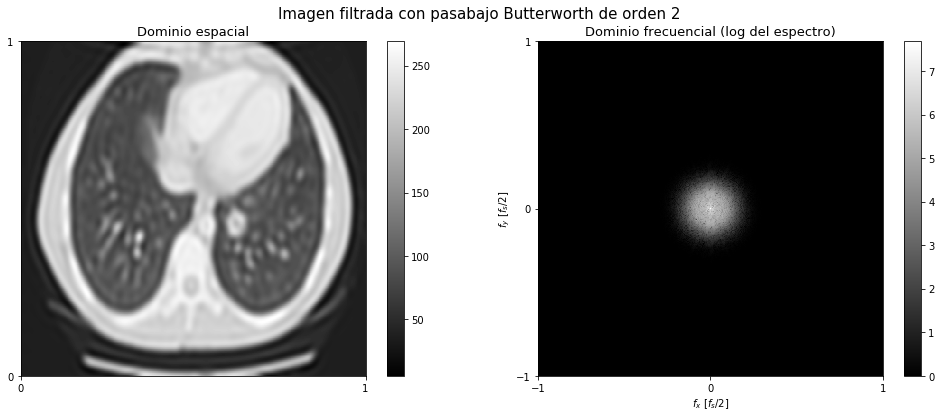

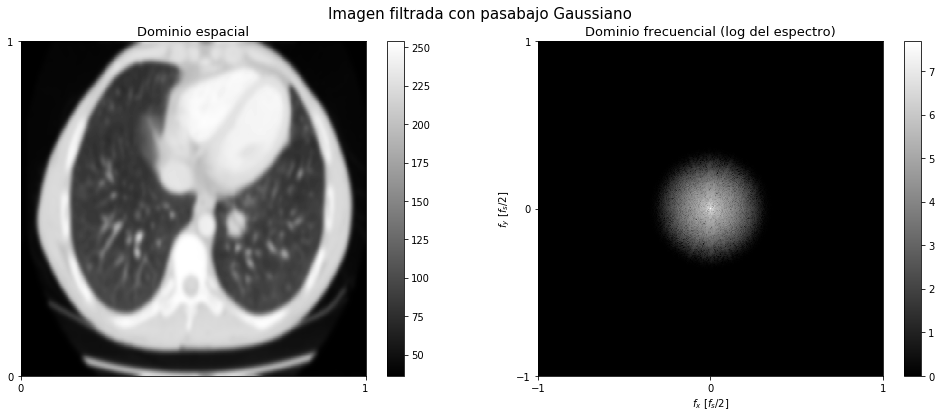

In [17]:
# Defino los filtros con una frecuencia de corte
# más restrictiva para observar mejor el efecto...
D0 = 0.1
ILPF_ = np.ones_like(D)
ILPF_[D>D0] = 0
BLPF_ = (1 + (D/D0)**(2*n))**(-1)
GLPF_ = np.exp(-D**2/D0**2)
filtros_pb_ = [ILPF_, BLPF_, GLPF_]

# Aplico filtrado...
for filtro, nombre in zip(filtros_pb_, nombres):
    G = F*filtro                             # producto en frecuencia
    g =  fft.ifft2(fft.ifftshift(G)).real    # descentro, antitransformo y me quedo con la parte real
    visualizar([g, G],'Imagen filtrada con ' # visualizo        
               'pasabajo ' + nombre)  

***Puede observarse el efecto se "blurring" en las tres transformaciones, similar al que se conseguía filtrando en el dominio espacial con kernel suavizantes. A su vez puede notarse un claro fenómeno de "ringing" en el filtro ideal, y en menor medida en el Butterworth. Por el contrario, el efecto del filtro gaussiano es más suave y no produce artefactos.***

***
## Filtros pasaaltos

***Usando el dominio de Fourier ya creado, y los pasabajos armados, creo los correspondientes pasaaltos como su complemento, con:***

$$
H_{HP} = 1 - H_{LP}
$$

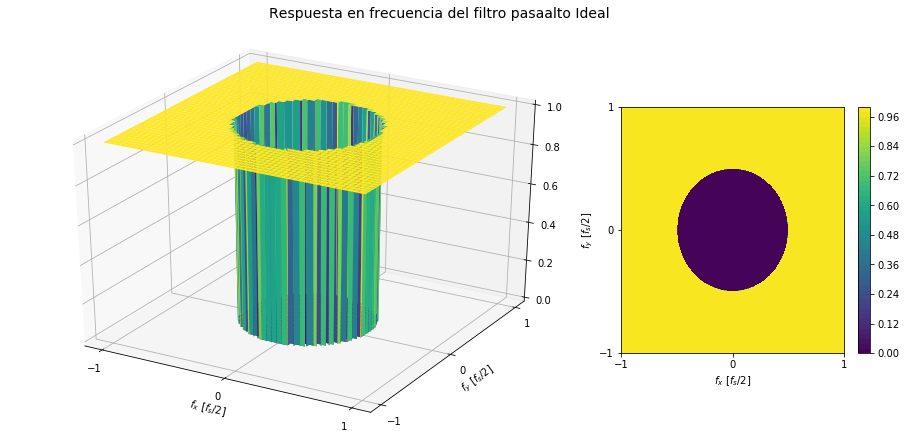

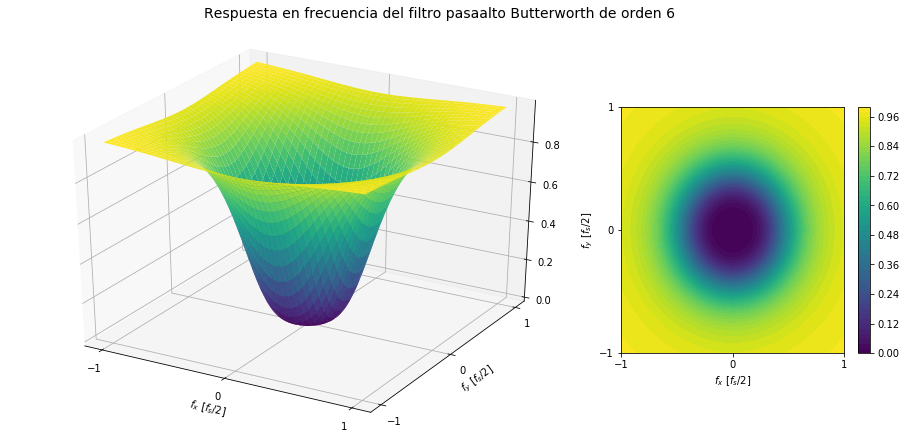

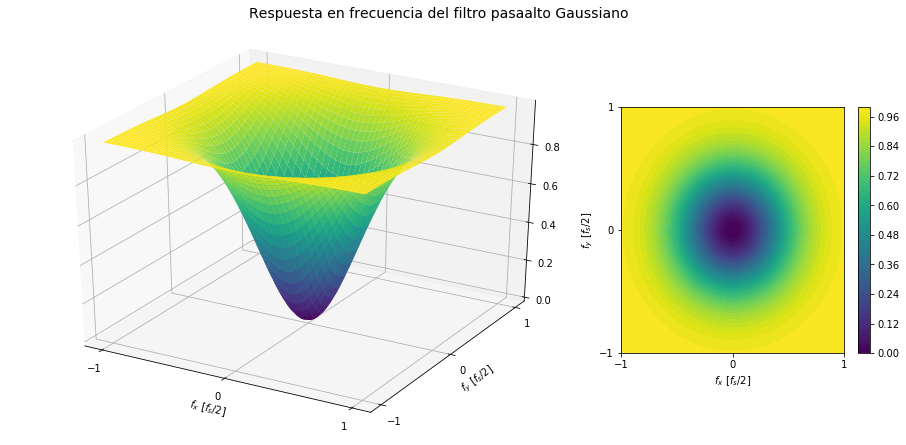

In [21]:
filtros_pa = [1 - filtro for filtro in filtros_pb]

# Visualizo las 3 rtas en frecuencia..
nombres = ['Ideal', 'Butterworth de orden {}'.format(n), 'Gaussiano']
for filtro, nombre in zip(filtros_pa, nombres):
    visualizar_filtro(filtro, 'pasaalto ' + nombre)

***Hago el producto elemento a elemento con la transfromada centrada de la imagen, vuelvo al domino espacial y visualizo...***

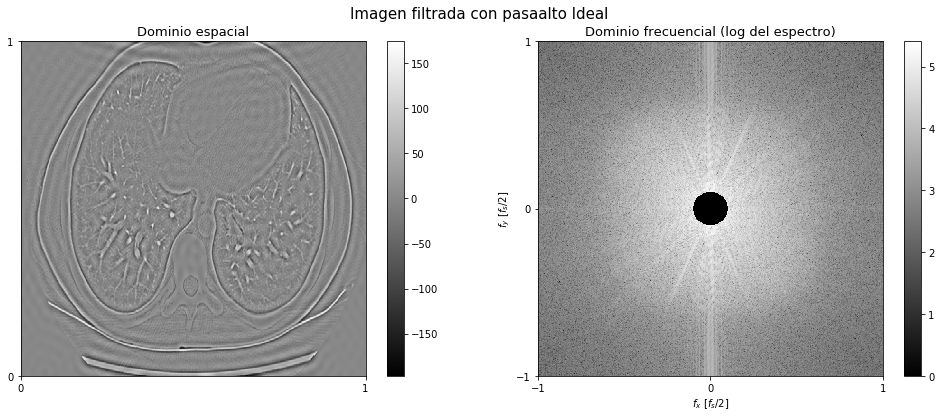

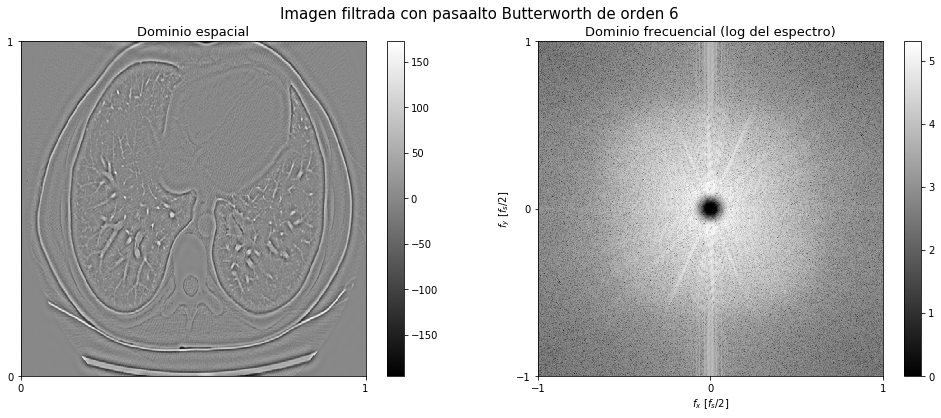

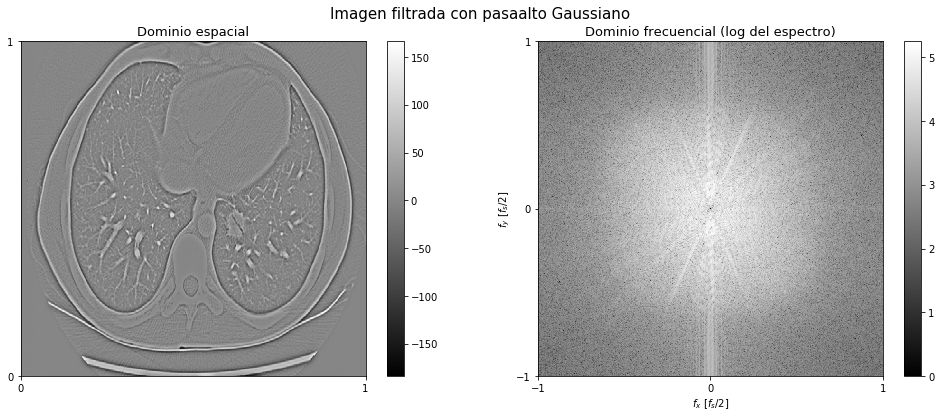

In [22]:
# Uso el complemento de los filtros con frecuecia de corte más restrictiva..
filtros_pa_ = [1 - filtro for filtro in filtros_pb_]

# Aplico filtrado...
for filtro, nombre in zip(filtros_pa_, nombres):
    G = F*filtro                             # producto en frecuencia
    g =  fft.ifft2(fft.ifftshift(G)).real    # descentro, antitransformo y me quedo c/real
    visualizar([g, G],'Imagen filtrada con ' # visualizo        
               'pasaalto ' + nombre)  

***En este caso puede observarse cómo los filtros que dejan pasar la banda de altas frecuencias crean una máscara con los bordes y las transiciones abruptas de la imagen, similar a la que se conseguía filtrando en espacio con el kernel laplaciano. Como en el módulo anterior, combinando esta imagen con la original puede obtenerse una imagen con bordes realzados. A su vez, nótese que también aparece el fenómento de "ringing", de forma evidente para el filtro Ideal, menos clara para el Butterworth, y ausente en el Gaussiano.***

***
## Función de filtrado

***Es posible armar una función que dada una imagen, una frecuencia de corte y un tipo de filtro, devuelva la imagen filtrada en dominio espacial y su espectro...***

In [23]:
def filtrado(img, fc=0.3, banda_p='B', filtro='G', n=2, plot=True):
    '''
    Función que aplica filtrado en frecuencia.
    Devuelve imagen filtrada en dominio espacial.
    Parámetros:
    -----------
    img:      {array 2D}. La imagen a filtrar (array, shape MxN).
    fc:       {int $ϵ[0,1]$}, opcional. Frecuencia de corte en unidades de la mitad
              de la frecuencia de muestreo.
    banda_p:  banda pasante, {'B', 'A'}, opcional. 'L' = baja; 'H' = alta.
    filtro:   {'I', 'B', 'G'}, opcional. Tipo de filtro: 'I' = ideal,
              'B' = Butterworth, 'G' = gaussiano.
    n:        int, opcional. Orden de filtro en caso de filtro = Butterworth.
    plot:     Bool, opcional. Opción de mostrar la imagen transformada y su espectro.
    '''
    
    assert (filtro in ['I', 'B', 'G'] and 
            banda_p in ['L', 'H'] and 
            (fc <=np.sqrt(2) and fc >= 0)),'Parámetro incorrecto'
    
    funcion = {'I': lambda D,fc,n: np.where(D>fc, 0, 1),
               'B': lambda D,fc,n: (1 + (D/fc)**(2*n))**(-1),
               'G': lambda D,fc,n: np.exp(-D**2/D0**2)
              }
    
    filtros_n = {'I': 'Ideal', 'B': 'Butterworth orden {}'.format(n),
                 'G': 'Gaussiano', 'L': 'bajo', 'H': 'alto'}
    
    stepfy, stepfx = 2/img.shape[0], 2/img.shape[1]
    wx, wy = np.meshgrid(np.arange(-1+stepfx/2, 1+stepfx/2, stepfx),
                     np.arange(-1+stepfy/2, 1+stepfy/2,stepfy))
    
    F = fft.fftshift(fft.fft2(img))
    
    D = (wx**2 + wy**2)**(1/2)
    H = funcion[filtro](D,fc,n)
    if banda_p == 'H': H = 1 - H
    G = F*H 
    img_f = fft.ifft2(fft.ifftshift(G)).real
    
    if plot:
        visualizar([img_f, G],'Imagen filtrada con pasa{} de tipo {}'
                   .format(filtros_n[banda_p], filtros_n[filtro]))
    return img_f

***Probando un par de ejemplos...***

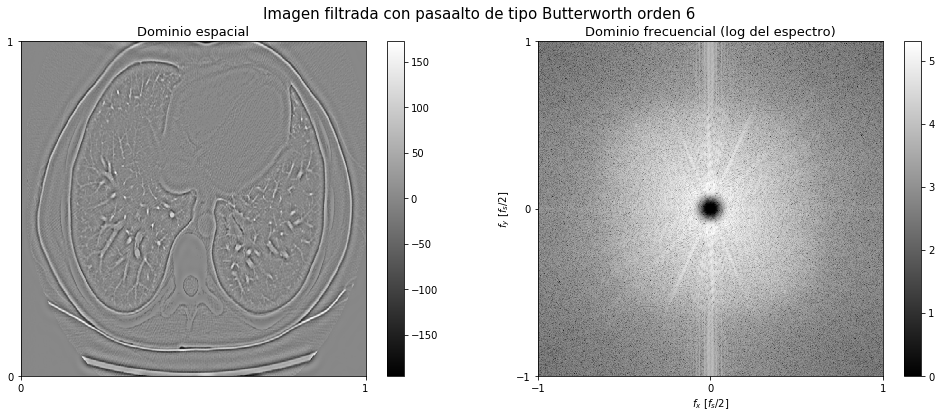

In [30]:
filtrado(img, fc=0.1, banda_p='H', filtro='B', n=6);

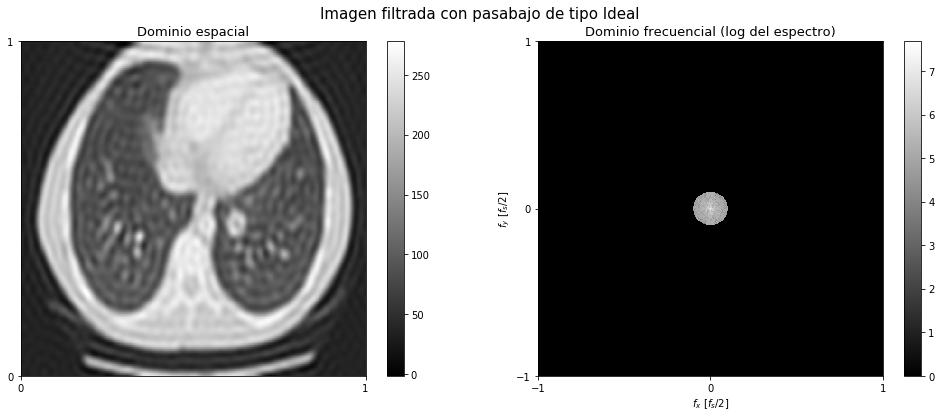

In [25]:
filtrado(img, fc=0.1, banda_p='L', filtro='I');

***Y con otras imágenes usadas previamente...***

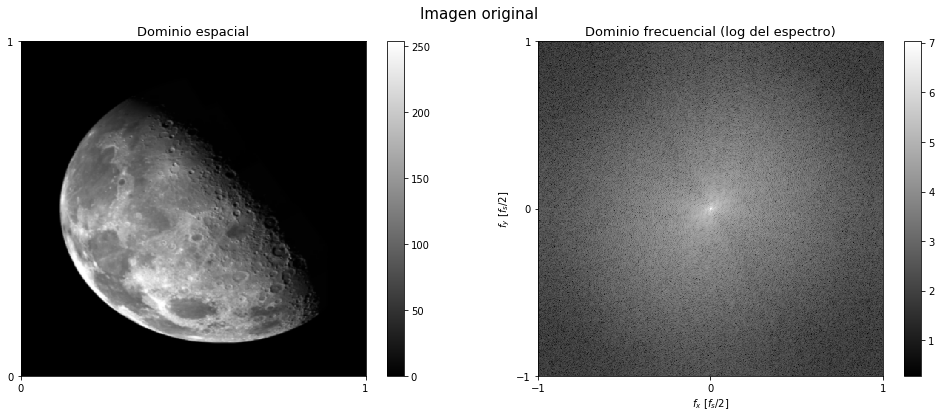

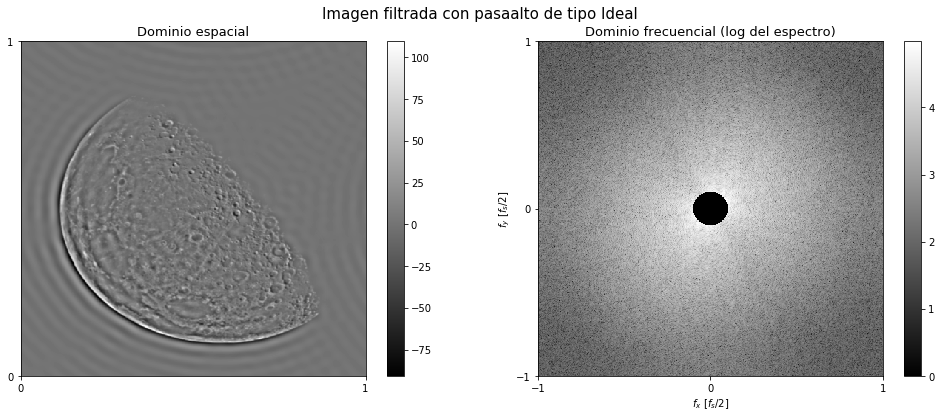

In [26]:
moon = mpl.image.imread('Data/blurry_moon.tif')
visualizar([moon, mi_fft(moon)], 'Imagen original')
filtrado(moon, fc=0.1, banda_p='H', filtro='I');

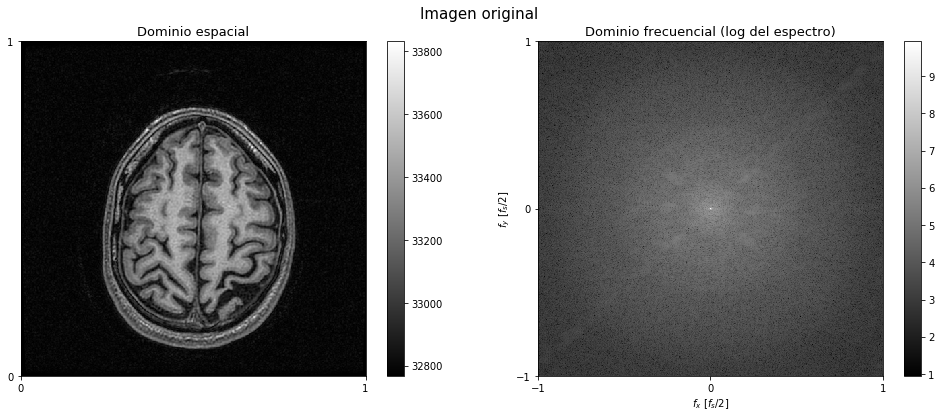

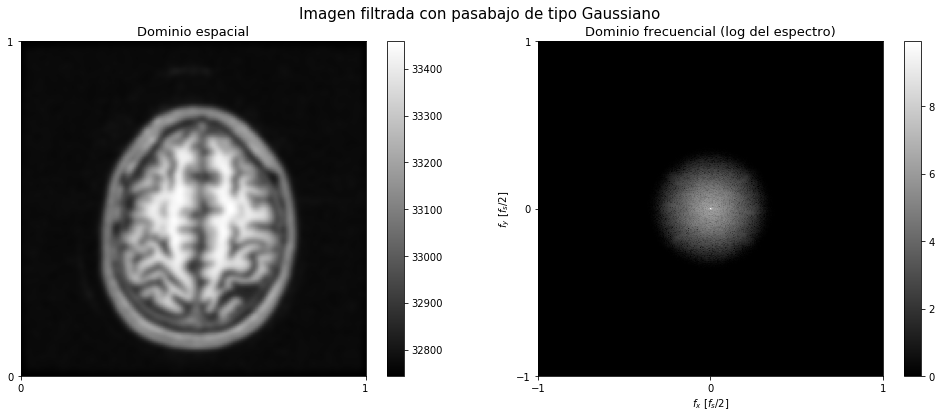

In [33]:
cerebro = mpl.image.imread('Data/cerebro.tif')
visualizar([cerebro, mi_fft(cerebro)], 'Imagen original')
filtrado(moon, fc=0.1, banda_p='L', filtro='G');

***
***

# 5.3 Actividad 14

***
>***Explorá la correspondencia entre el dominio frecuencial y el dominio espacial de los filtros.
Para eso, partí de los filtros en el dominio espacial h, generá la función de respuesta en el dominio frecuencial H, y compará el resultado del filtrado en ambos dominios.***
***

***...***

***
***
<h1 style="color:green;font-size:50px;"><center>FIN!</center></h1>

***
***
***